In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import skimage
from skimage import color
from skimage.color import rgb2hsv
import math
# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get Mnist data and split into train validation and test

In [2]:
def get_mnist():

    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get CIFAR10 data and split into train validation and test

In [3]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)



# Get transformed Mnist data

In [4]:
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

# Convolution layer with relu

In [5]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

# Fully connected layer

In [6]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

# The network

In [7]:
#tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [8]:
#tf.reset_default_graph()

def my_create_network_deeper():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=250)
            fc1r=tf.nn.relu(fc1)
            
    with tf.variable_scope("fc1_2"):
            fc1_2 = fully_connected_layer(fc1r, num_features=128)
            fc1r_2=tf.nn.relu(fc1_2)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r_2, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

# Get loss and accuracy on a data set with output from final layer fc2

In [9]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

# Run one epoch

In [10]:

# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [11]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

# Plot images

In [12]:
## reference https://github.com/Hvass-Labs/TensorFlow-Tutorials

def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# (a) Read in data and display

In [13]:
train,val,test = get_cifar()

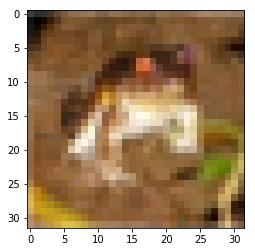

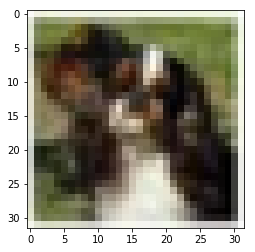

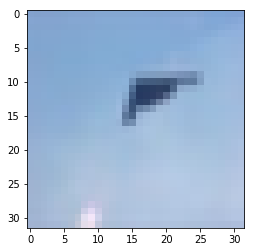

In [14]:
plt.imshow(train[0][0,:].reshape(32,32,3))
plt.show()
plt.imshow(train[0][500,:].reshape(32,32,3))
plt.show()
plt.imshow(train[0][12121,:].reshape(32,32,3))
plt.show()

# (b) run with original model

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 3, 32] 0.046984356
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028825352
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021429416
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.086599186
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.9990837574005127
get stats time 0.493161678314209
Epoch 0 Train loss, accuracy 1.863172179853916 0.3278
get stats time 0.161482572555542
EPoch 0 Validation loss, accuracy 1.8868865665435792 0.3156
Batch 0.0
Batch 10.0
Epoch time 0.87320876121521
Batch 0.0
Batch 10.0
Epoch time 0.8846406936645508
get stats time 0.2910654544830322
Epoch 2 Train loss, accuracy 1.5180832846283914 0.46369999999999995
get stats time 0.15743207931518555
EPoch 2 Validation loss, accuracy 1.5773222689151765 0.43179999999999996
Batch 0.0
Batch 10.0
Epoch time 0.8718745708465576
Batch 0.

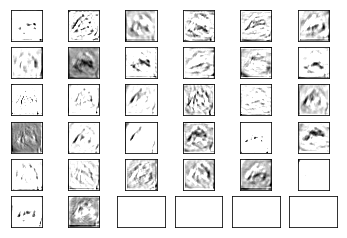

Model saved in path: tmp/model


In [14]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                err_train.append(1-ac)
                
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy

        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        ## my show images 
        image = train[0][0]
        w_out = tf.trainable_variables()[0]
        b_out = tf.trainable_variables()[1]
        conv = tf.nn.conv2d(x_image, w_out, strides=[1, 1, 1, 1], padding='SAME')
        ## conv2d : arbitrary filters that can mix channels together
        relu = tf.nn.relu(conv + b_out)
        plot_conv_layer(relu, image)
        
        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)



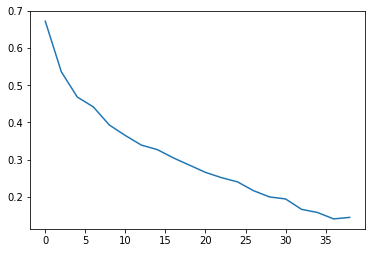

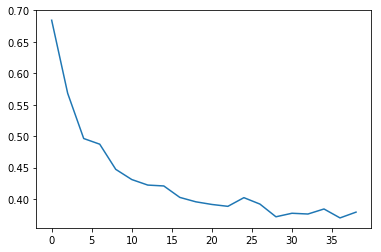

In [18]:
es = [2*i for i in range(len(err_train))]
plt.plot(es,err_train)
plt.show()
plt.plot(es,err_val)
plt.show()

# (C) deeper network
I added an additional layer fc1_2 and the size of fc1 and fc1_2 are 250 and 128. From the experiment above, I cannot see obvious improvement (from 0.5843 to 0.5991)

In [14]:
# Run the training
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model_deeper"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

err_train_d = []
err_val_d = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_deeper()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                err_train_d.append(1-ac)
                
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                
                err_val_d.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy

        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 3, 32] 0.047396977
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028806174
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 250] 0.021458508
fc1/b:0 [250] 0.0
fc1_2/W:0 [250, 128] 0.07284773
fc1_2/b:0 [128] 0.0
fc2/W:0 [128, 10] 0.1187846
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.9196546077728271
get stats time 0.500112771987915
Epoch 0 Train loss, accuracy 1.8630122694849969 0.31980000000000003
get stats time 0.16240453720092773
EPoch 0 Validation loss, accuracy 1.8936020859718323 0.3126
Batch 0.0
Batch 10.0
Epoch time 0.8744633197784424
Batch 0.0
Batch 10.0
Epoch time 0.867276668548584
get stats time 0.2916390895843506
Epoch 2 Train loss, accuracy 1.4893339892983437 0.4631
get stats time 0.14678430557250977
EPoch 2 Validation loss, accuracy 1.530170536351204 0.4468
Batch 0.0
Batch 10.

## Comment
There is improvement when I add a layer between fc1 and fc2, from 0.5843 to 0.6013

# (d) Variability

In [14]:
from skimage import color
from skimage.color import rgb2hsv

In [15]:
train, val,  test = get_cifar()

In [16]:
import random
random.seed(12345)
test_image = test[0].copy()
test_image_hsv = [skimage.color.rgb2hsv(x.reshape(32,32,3)) for x in test_image]

def change_h(x):
    x[:,:,1] = random.uniform(0.75,1.25)*x[:,:,1]
    return x

test_image_hsv_t = list(map(change_h,test_image_hsv))
test_image_rgb_t = [skimage.color.hsv2rgb(x) for x in test_image_hsv_t]

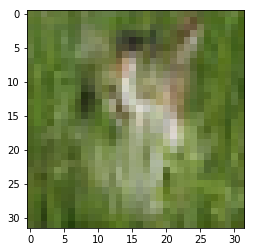

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


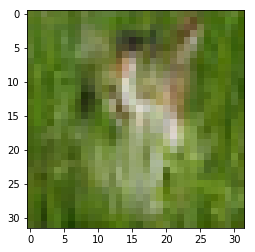

In [18]:
pick = 456
plt.imshow(test[0][pick,:].reshape(32,32,3))
plt.show()
plt.imshow(test_image_rgb_t[pick])
plt.show()

In [14]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                err_train.append(1-ac)
                
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy

        import random
        random.seed(12345)
        test_image = test[0].copy()
        test_image_hsv = [skimage.color.rgb2hsv(x.reshape(32,32,3)) for x in test_image]

        def change_h(x):
            x[:,:,1] = random.uniform(0.75,1.25)*x[:,:,1]
            return x
        test_image_hsv_t = list(map(change_h,test_image_hsv))
        test_image_rgb_t = [skimage.color.hsv2rgb(x) for x in test_image_hsv_t]
        test_t = [x.reshape(3072) for x in test_image_rgb_t]
        test_t = np.array(test_t)
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test_t, y_:test[1]}))
        


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 3, 32] 0.047007147
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.0289418
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021446623
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08665953
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.9462459087371826
get stats time 0.49600839614868164
Epoch 0 Train loss, accuracy 1.856021707868576 0.33330000000000004
get stats time 0.15366435050964355
EPoch 0 Validation loss, accuracy 1.8720796416521073 0.3266
Batch 0.0
Batch 10.0
Epoch time 0.8878448009490967
Batch 0.0
Batch 10.0
Epoch time 0.8631460666656494
get stats time 0.3151071071624756
Epoch 2 Train loss, accuracy 1.5241077013254167 0.457
get stats time 0.15688180923461914
EPoch 2 Validation loss, accuracy 1.5786763971090316 0.4298
Batch 0.0
Batch 10.0
Epoch time 0.860346794128418
Batch 0.0
Batch 10.0

## Comment
The test accuracy on the transformed data does not change much. This time it even performs better, with a 0.6018 accuracy rate compared with 0.5969 in unchanged data.